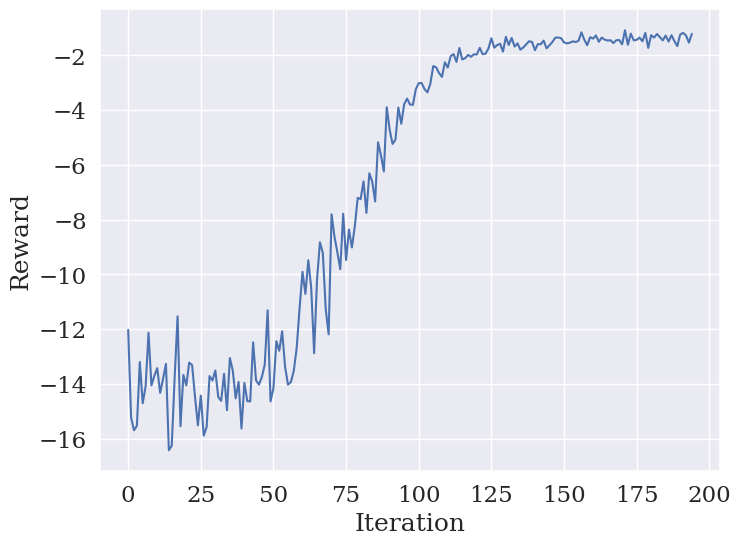

In [28]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'


from poclaps.train.ppo import reload

policy_dir = 'outputs/2024-06-14/15-39-35/'
config, pretrained_policy, env, env_params, _ = reload(policy_dir)

import pandas as pd
from reproducible_figures import save_reproducible_figure, set_plotting_style
import matplotlib.pyplot as plt


policy_training_metrics = pd.read_csv(f'{policy_dir}/metrics.csv')

def plot_policy_training_history(policy_training_metrics):
    set_plotting_style()
    _, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(policy_training_metrics['iteration'], policy_training_metrics['mean_reward'])
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Reward')


plot_policy_training_history(policy_training_metrics)

In [29]:
dict(config)

{'algorithm': 'PPO',
 'learning_rate': 0.00025,
 'num_envs': 4,
 'num_steps': 128,
 'total_timesteps': 100000.0,
 'update_epochs': 4,
 'num_minibatches': 4,
 'gamma': 0.99,
 'gae_lambda': 0.95,
 'clip_eps': 0.2,
 'ent_coef': 0.01,
 'vf_coef': 0.5,
 'max_grad_norm': 0.5,
 'activation': 'tanh',
 'anneal_lr': True,
 'seed': 0,
 'env_name': 'SimpleGridWorld-v0',
 'env_kwargs': {'grid_size': 5, 'max_steps_in_episode': 20},
 'wandb_entity': 'drcope',
 'wandb_project': 'ppo-gridworld-example',
 'wandb_mode': 'online',
 'num_updates': 195.0,
 'minibatch_size': 128}

In [30]:
from typing import Iterable
from poclaps.simple_gridworld_game import stringify_grid


def get_goals_and_pos(obs):
    """
    Args:
        obs: (T, n_envs, 20) shaped array of observations.
    Returns:
        goal_pos: (T, n_envs, 2) shaped array of goal positions.
        agent_pos: (T, n_envs, 2) shaped array of agent positions.
    """
    *batch_shape, _ = obs.shape
    env_states = obs.reshape((*batch_shape, 2, 2, 5)).argmax(-1)

    agent_pos = env_states[:, :, 0]
    goal_pos = env_states[:, :, 1]

    return goal_pos, agent_pos


def format_side_by_side(strings: Iterable[str]) -> str:
    """
    Format strings side by side. Assumes all strings have the same number of
    lines and each line has the same number of characters.
    """
    return '\n'.join([
        '\t'.join(lines)
        for lines in zip(*[g.split('\n') for g in strings])
    ])


def print_episode(goals, agent_pos):
    grid_strings = []

    for g, p in zip(goals, agent_pos):
        grid_str = stringify_grid(env_params.grid_size, {
            tuple(p): 'X', tuple(g): 'G'
        })
        grid_strings.append(grid_str)

    print(format_side_by_side(grid_strings))

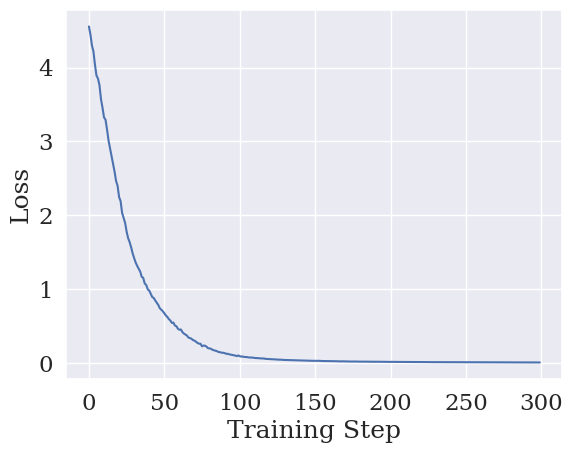

reformatted figures/transition_model_loss/code.py

All done! ✨ 🍰 ✨
1 file reformatted.


In [31]:
import flax.linen as nn
import jax.numpy as jnp


class TransitionModel(nn.Module):
    obs_dim: int
    hidden_dim: int = 256

    @nn.compact
    def __call__(self, inputs):
        """
        Args:
            obs: (B, D)
            action: (B, A)
        """
        actions, obs = inputs
        x = jnp.concatenate([obs, actions], axis=-1)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.relu(x)
        x = nn.Dense(self.obs_dim)(x)

        return x


import jax
from poclaps.rollout_fake_msgs import rollout_with_msgs


N_ACTIONS = env.action_space(env_params).n


def sample_transition_modelling_batch(rng,
                                      rollout_steps: int = 500):
    rng, rollout_rng = jax.random.split(rng)
    _, traj_batch, _ = rollout_with_msgs(
        env, env_params, pretrained_policy,
        steps=rollout_steps,
        rng=rollout_rng
    )
    actions = jax.nn.one_hot(traj_batch.action, N_ACTIONS)
    start_obs, next_obs = traj_batch.obs[:-1], traj_batch.obs[1:]
    actions = actions[:-1]
    dones_mask = 1.0 - traj_batch.done[:-1]
    return (actions, start_obs), next_obs, dones_mask


from poclaps.train.losses import categorical_cross_entropy


def obs_loss_fn(act_obs, pred_obs_logits):
    n_steps, n_envs, obs_dim = act_obs.shape
    act_env_state = act_obs.reshape((n_steps, n_envs, 2, 2, obs_dim // 4))
    pred_env_state = pred_obs_logits.reshape((n_steps, n_envs, 2, 2, obs_dim // 4))

    # 1h vecs for actual positions
    act_agent_pos_x = act_env_state[:, :, 0, 0]
    act_agent_pos_y = act_env_state[:, :, 0, 1]
    act_goal_pos_x = act_env_state[:, :, 1, 0]
    act_goal_pos_y = act_env_state[:, :, 1, 1]

    # 1h vecs for predicted positions
    pred_agent_pos_x = pred_env_state[:, :, 0, 0]
    pred_agent_pos_y = pred_env_state[:, :, 0, 1]
    pred_goal_pos_x = pred_env_state[:, :, 1, 0]
    pred_goal_pos_y = pred_env_state[:, :, 1, 1]

    # CCE loss for positions
    cce_x = categorical_cross_entropy(pred_agent_pos_x, act_agent_pos_x)
    cce_y = categorical_cross_entropy(pred_agent_pos_y, act_agent_pos_y)
    cce_goal_x = categorical_cross_entropy(pred_goal_pos_x, act_goal_pos_x)
    cce_goal_y = categorical_cross_entropy(pred_goal_pos_y, act_goal_pos_y)

    return cce_x + cce_y + cce_goal_x + cce_goal_y


from flax.training.train_state import TrainState
import optax
import chex

N_ROLLOUT_STEPS = 500
N_TRAIN_STEPS = 300


@jax.jit
def update_fn(state: tuple, _):
    train_state, rng = state

    def compute_loss(params, batch):
        inputs, next_obs, dones_mask = batch
        next_obs_preds_logits = train_state.apply_fn(params, inputs)
        loss_vals = dones_mask * obs_loss_fn(next_obs, next_obs_preds_logits)
        return loss_vals.mean()

    rng, _rng = jax.random.split(rng)
    batch = sample_transition_modelling_batch(_rng, N_ROLLOUT_STEPS)
    loss, grads = jax.value_and_grad(compute_loss)(train_state.params, batch)
    new_train_state = train_state.apply_gradients(grads=grads)
    metrics = {'loss': loss, 'step': train_state.step}
    return (new_train_state, rng), metrics


rng = jax.random.PRNGKey(0)

rng, _rng = jax.random.split(rng)
inputs, *_ = sample_transition_modelling_batch(_rng, N_ROLLOUT_STEPS)
transition_model = TransitionModel(env.observation_space(env_params).shape[0])
init_params = transition_model.init(jax.random.PRNGKey(0), inputs)
optimizer = optax.adam(1e-3)
transition_model_train_state = TrainState.create(
    apply_fn=transition_model.apply,
    params=init_params,
    tx=optimizer
)

(transition_model_train_state, _), metrics = jax.lax.scan(
    update_fn, (transition_model_train_state, rng), None, length=N_TRAIN_STEPS
)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from reproducible_figures import save_reproducible_figure, set_plotting_style

def plot(df):
    set_plotting_style()
    ax = sns.lineplot(df, x='step', y='loss')
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Loss')

df = pd.DataFrame({
    'loss': metrics['loss'],
    'step': metrics['step']
})

save_reproducible_figure('transition_model_loss', df, plot, show=True)

In [ ]:
from poclaps.rollout_fake_msgs import rollout_with_msgs


def create_rollout_state_with_fixed_goal_pos(game_rng, goal_pos_rng, n_seqs):
    rng, reset_rng = jax.random.split(game_rng)
    reset_rng = jax.random.split(reset_rng, n_seqs)
    _, env_state = jax.vmap(env.reset,
                            in_axes=(0, None))(reset_rng, env_params)

    set_goal_pos = jax.random.randint(goal_pos_rng, (2,), 0, env.grid_size)

    env_state = env_state.replace(
        env_state=env_state.env_state.replace(
            goal_pos=jnp.repeat(set_goal_pos[None], n_seqs, axis=0)
        )
    )

    obsv = jax.vmap(env.get_obs)(env_state.env_state)

    ep_ids = jnp.arange(n_seqs)
    return (env_state, obsv, rng, ep_ids)


def sample_sequences(rng,
                     n_seqs=64,
                     seq_len=8,
                     comm_policy_seed=0,
                     action_sample_temp: float = 1.0,
                     rollout_state=None,
                     fix_goal_pos_seed=None,
                     fix_goal_pos_in_batch: bool = False):
    """
    Returns:
        (actions_1h, msgs_1h, seq_mask): 1h vectors for actions and messages,
            and a mask for sequences.
        obs: (T, n_envs, 20) shaped array of observations.
    """

    rng, rollout_rng = jax.random.split(rng)

    if fix_goal_pos_in_batch or fix_goal_pos_seed is not None:
        if fix_goal_pos_seed is not None:
            goal_pos_rng = jax.random.PRNGKey(fix_goal_pos_seed)
            rollout_rng, game_rng = jax.random.split(rollout_rng)
        else:
            rollout_rng, game_rng, goal_pos_rng = jax.random.split(rollout_rng, 3)
        rollout_state = create_rollout_state_with_fixed_goal_pos(
            game_rng, goal_pos_rng, n_seqs
        )

    _, traj_batch, _ = rollout_with_msgs(
        env, env_params, pretrained_policy,
        steps=seq_len,
        n_envs=n_seqs,
        rng=rollout_rng,
        action_sample_temp=action_sample_temp,
        comm_policy_seed=comm_policy_seed,
        rollout_state=rollout_state
    )

    def compute_seq_mask(done_carry, done_t):
        # when done_t is True, the sequence is finished
        # but we want to include this in the sequence
        # so we set the mask to False on the last step,
        # we we can detect because done_carry is still false
        not_carry = jnp.logical_not(done_carry)
        is_last = jnp.logical_and(done_t, not_carry)
        is_part_of_seq = jnp.logical_or(is_last, not_carry)
        mask_val = jnp.logical_not(is_part_of_seq)
        done_carry = jnp.logical_or(done_carry, done_t)
        return done_carry, mask_val

    done_carry = jnp.zeros((n_seqs,), dtype=bool)
    _, seq_mask = jax.lax.scan(
        compute_seq_mask, done_carry, traj_batch.done
    )
    # True = sequence finished, False = sequence not finished
    too_short = jnp.repeat((seq_mask.argmax(0) < 1)[np.newaxis, ...], seq_len, axis=0)
    # sequences that are too short should not be used
    seq_mask = jnp.logical_or(too_short, seq_mask)

    n_msgs = env_params.grid_size * env_params.grid_size
    actions_1h = jax.nn.one_hot(traj_batch.action, N_ACTIONS)
    msgs_1h = jax.nn.one_hot(traj_batch.message, n_msgs)

    return (actions_1h, msgs_1h, rng, seq_mask), traj_batch


from tkinter import Y
import flax.linen as nn
import numpy as np
import jax.numpy as jnp
import jax
import functools


class ScannedRNN(nn.Module):
    hidden_size: int = 128

    @functools.partial(
        nn.scan,
        variable_broadcast="params",
        in_axes=0,
        out_axes=0,
        split_rngs={"params": False},
    )
    @nn.compact
    def __call__(self, rnn_state, x):
        """Applies the module."""
        ins, seq_mask = x
        new_rnn_state, y = nn.GRUCell(features=self.hidden_size)(rnn_state, ins)
        new_rnn_state = jnp.where(
            seq_mask[:, np.newaxis],
            rnn_state,
            new_rnn_state,
        )
        return new_rnn_state, y

    @staticmethod
    def initialize_carry(n_envs, hidden_size):
        # Use a dummy key since the default state init fn is just zeros.
        cell = nn.GRUCell(features=hidden_size)
        return cell.initialize_carry(jax.random.PRNGKey(0), (n_envs, hidden_size))


class ActionsMsgsEncoder(nn.Module):
    enc_size: int
    hidden_size: int = 128
    n_preprocess_layers: int = 2

    @nn.compact
    def __call__(self, inputs):
        actions, msgs, rng, seq_mask = inputs
        feats = jnp.concatenate([actions, msgs], axis=-1)

        for _ in range(self.n_preprocess_layers):
            x = nn.Dense(self.hidden_size)(feats)
            x = nn.relu(x)

        _, n_envs, _ = x.shape
        carry = ScannedRNN.initialize_carry(n_envs, self.hidden_size)
        action_enc, _ = ScannedRNN(self.hidden_size)(carry, (x, seq_mask))

        return nn.Dense(self.enc_size)(action_enc)


class SeqEncoder(nn.Module):
    enc_size: int
    hidden_size: int = 128
    n_layers: int = 2

    @nn.compact
    def __call__(self, inputs):
        x, seq_mask = inputs

        for _ in range(self.n_layers):
            x = nn.Dense(self.hidden_size)(x)
            x = nn.relu(x)

        _, batch_size, _ = x.shape
        carry = ScannedRNN.initialize_carry(batch_size, self.hidden_size)
        enc, y = ScannedRNN(self.hidden_size)(carry, (x, seq_mask))

        return nn.Dense(self.enc_size)(enc), y


from tensorflow_probability.substrates import jax as tfp


def relaxed_sample_obs(logits, rng, temp=0.1):
    n_envs, *_ = logits.shape
    env_states_logits = logits.reshape((n_envs, 2, 2, 5))

    agent_pos_x_logits = env_states_logits[:, 0, 0]
    agent_pos_y_logits = env_states_logits[:, 0, 1]
    goal_pos_x_logits = env_states_logits[:, 1, 0]
    goal_pos_y_logits = env_states_logits[:, 1, 1]

    agent_x_dist = tfp.distributions.RelaxedOneHotCategorical(
        temp, logits=agent_pos_x_logits
    )
    rng, _rng = jax.random.split(rng)
    agent_pos_x = agent_x_dist.sample(seed=_rng)

    agent_y_dist = tfp.distributions.RelaxedOneHotCategorical(
        temp, logits=agent_pos_y_logits
    )
    rng, _rng = jax.random.split(rng)
    agent_pos_y = agent_y_dist.sample(seed=_rng)

    goal_x_dist = tfp.distributions.RelaxedOneHotCategorical(
        temp, logits=goal_pos_x_logits
    )
    rng, _rng = jax.random.split(rng)
    goal_pos_x = goal_x_dist.sample(seed=_rng)

    goal_y_dist = tfp.distributions.RelaxedOneHotCategorical(
        temp, logits=goal_pos_y_logits
    )
    rng, _rng = jax.random.split(rng)
    goal_pos_y = goal_y_dist.sample(seed=_rng)

    return jnp.concatenate(
        # listener obs, speaker obs
        [agent_pos_x, agent_pos_y, goal_pos_x, goal_pos_y],
        axis=-1
    )


class InitObsModel(nn.Module):
    speaker_obs_dim: int
    listener_obs_dim: int
    hidden_dim: int = 256
    n_layers: int = 3

    @nn.compact
    def __call__(self, msgs_enc, action_msgs_enc, _rng, temp=0.1):
        """
        Args:
            noise: (B, D)
        """

        x = msgs_enc
        for _ in range(self.n_layers):
            x = nn.Dense(self.hidden_dim)(x)
            x = nn.relu(x)
        speaker_obs_logits = nn.Dense(self.speaker_obs_dim)(x)

        y = action_msgs_enc
        for _ in range(self.n_layers):
            y = nn.Dense(self.hidden_dim)(y)
            y = nn.relu(y)
        listener_obs_logits = nn.Dense(self.listener_obs_dim)(y)

        obs_logits = jnp.concatenate([
            listener_obs_logits, speaker_obs_logits
        ], axis=-1)

        return relaxed_sample_obs(
            obs_logits, _rng, temp=temp
        )


class ObsActionDecoder(nn.Module):
    obs_dim: int
    hidden_size: int = 128

    @nn.compact
    def __call__(self, inputs, temp: float = 0.1):
        actions, msgs, rng, seq_mask = inputs
        seq_len, n_seqs = seq_mask.shape

        # msgs_enc, _ = SeqEncoder(self.hidden_size)((msgs, seq_mask))
        action_msgs_enc = ActionsMsgsEncoder(self.hidden_size)(inputs)
        rng, _rng = jax.random.split(rng)
        init_obs_model = InitObsModel(
            self.obs_dim // 2, self.obs_dim // 2, self.hidden_size
        )
        init_obs = init_obs_model(
            msgs[0], action_msgs_enc, _rng, temp=temp
        )

        def simulate_rollout_step(obs, inputs):
            """
            Uses the pretrained policy and transition function to simulate
            a step of a rollout from the given observation.
            """
            step_rng, action = inputs
            action_rng, obs_rng = jax.random.split(step_rng)
            pi, *_ = pretrained_policy(obs)
            action_logits = pi.logits
            # action_dist = tfp.distributions.RelaxedOneHotCategorical(
            #     temp, logits=action_logits
            # )
            # action_probs = action_dist.sample(seed=action_rng)
            # action_probs = jax.nn.softmax(action_logits / temp)
            # transition_inp = (action_probs, obs)
            transition_inp = (action, obs)
            next_obs_logits = transition_model.apply(
                transition_model_train_state.params,
                transition_inp
            )
            next_obs = relaxed_sample_obs(
                next_obs_logits, obs_rng, temp=temp
            )
            return next_obs, (next_obs, action_logits)

        step_rngs = jax.random.split(rng, seq_len)
        _, (obs_preds, action_logits) = jax.lax.scan(
            simulate_rollout_step, init_obs, (step_rngs, actions)
        )

        # include the initial observation in the predictions and remove
        # the last prediction to match the shape of the input observations
        obs_preds = jnp.concatenate([init_obs[None], obs_preds[:-1]], axis=0)

        return obs_preds, action_logits

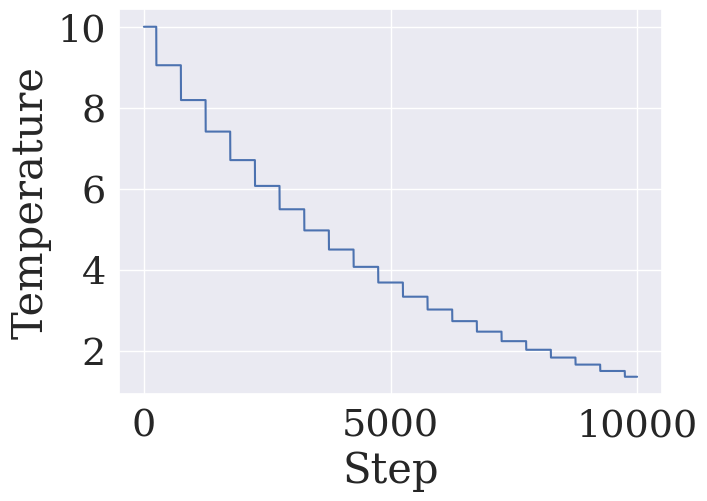

reformatted figures/state_decoding_23-11-24-early-stop/temperature_schedule/code.py

All done! ✨ 🍰 ✨
1 file reformatted.


In [85]:
EXPERIMENT_NAME = '23-11-24-early-stop'
BATCH_SIZE = 512
SEQ_LEN = 8
N_TRAIN_STEPS = 10000

HIGH_TEMP = 10.0
LOW_TEMP = 0.5
ROUND_FAC = 500
SCHEDULE_STEPS = 15000
ACTION_SAMPLE_TEMPERATURE = 0.01
ENTROPY_BONUS_COEFF = 0.0
MODEL_HIDDEN_SIZE = 256


def linear_temp_schedule(step,
                         high_t = HIGH_TEMP,
                         low_t = LOW_TEMP,
                         schedule_steps = SCHEDULE_STEPS,
                         round_fac = ROUND_FAC):
    step = jnp.int32(jnp.round(step / round_fac, 0) * round_fac)
    return jnp.clip(high_t - (high_t - low_t) * (step / schedule_steps), low_t)


def exponential_temp_schedule(step,
                              high_t = HIGH_TEMP,
                              low_t = LOW_TEMP,
                              schedule_steps = SCHEDULE_STEPS,
                              round_fac = ROUND_FAC):
    step = jnp.int32(jnp.round(step / round_fac, 0) * round_fac)
    decay_fac = jnp.log(low_t / high_t) / schedule_steps
    temp = high_t * jnp.exp(decay_fac * step)
    return jnp.clip(temp, low_t, high_t)


def plot_temp_schedules(schedule_df: pd.DataFrame):
    set_plotting_style(font_scale=2.5)
    _, ax = plt.subplots(figsize=(7, 5))
    sns.lineplot(x='step', y='temp', data=schedule_df, ax=ax)
    ax.set_xlabel('Step')
    ax.set_ylabel('Temperature')

sample_training_batch = functools.partial(
    sample_sequences,
    n_seqs=BATCH_SIZE,
    seq_len=SEQ_LEN,
    action_sample_temp=ACTION_SAMPLE_TEMPERATURE
)

temp_schedule = exponential_temp_schedule

schedule_df = pd.DataFrame({
    'step': np.arange(N_TRAIN_STEPS),
    'temp': temp_schedule(np.arange(N_TRAIN_STEPS))
})

save_reproducible_figure(
    'temperature_schedule',
    schedule_df, plot_temp_schedules, show=True,
    figures_dir=f'figures/state_decoding_{EXPERIMENT_NAME}'
)

In [86]:
def compute_init_obs_entropy_bonus(obs_preds, seq_mask):
    init_obs = obs_preds[0]
    env_states = init_obs.reshape((-1, 2, 2, 5))
    agent_pos_x_logits = env_states[:, 0, 0]
    agent_pos_y_logits = env_states[:, 0, 1]
    goal_pos_x_logits = env_states[:, 1, 0]
    goal_pos_y_logits = env_states[:, 1, 1]

    def _entropy(logits):
        dist = tfp.distributions.Categorical(logits=logits)
        return dist.entropy()

    agent_pos_x_entropy = _entropy(agent_pos_x_logits)
    agent_pos_y_entropy = _entropy(agent_pos_y_logits)
    goal_pos_x_entropy = _entropy(goal_pos_x_logits)
    goal_pos_y_entropy = _entropy(goal_pos_y_logits)
    
    entropy_vals = (
        agent_pos_x_entropy + agent_pos_y_entropy +
        goal_pos_x_entropy + goal_pos_y_entropy
    )

    mask = 1.0 - seq_mask
    return (mask * entropy_vals).sum() / mask.sum()

def compute_goal_pred_acc(obs_preds, traj_batch, seq_mask):
    pred_goal_pos, _ = get_goals_and_pos(obs_preds)
    act_goal_pos, _ = get_goals_and_pos(traj_batch.obs)
    goals_equal = pred_goal_pos == act_goal_pos
    mask = 1.0 - seq_mask
    acc = (mask * goals_equal.all(axis=-1)).sum() / mask.sum()
    return acc


def compute_agent_pos_pred_acc(obs_preds, traj_batch, seq_mask):
    _, pred_agent_pos = get_goals_and_pos(obs_preds)
    _, act_agent_pos = get_goals_and_pos(traj_batch.obs)
    agent_pos_equal = pred_agent_pos == act_agent_pos
    mask = 1.0 - seq_mask
    acc = (mask * agent_pos_equal.all(axis=-1)).sum() / mask.sum()
    return acc


from flax.training.train_state import TrainState
import optax


@jax.jit
def update_fn(state: tuple, _):
    train_state, rng = state

    temp = temp_schedule(train_state.step)

    def compute_loss_and_metrics(params, batch):
        inputs, traj_batch = batch
        obs_preds, action_pred_logits = train_state.apply_fn(params, inputs, temp=temp)
        true_actions, _, _, seq_mask = inputs

        loss_mask = 1.0 - seq_mask
        loss_vals = loss_mask * categorical_cross_entropy(
            action_pred_logits, true_actions
        )
        loss = loss_vals.sum() / loss_mask.sum()

        goal_pred_acc = compute_goal_pred_acc(
            obs_preds, traj_batch, seq_mask
        )
        agent_pos_pred_acc = compute_agent_pos_pred_acc(
            obs_preds, traj_batch, seq_mask
        )
        metrics = {
            'goal_pred_acc': goal_pred_acc,
            'agent_pos_pred_acc': agent_pos_pred_acc
        }

        if ENTROPY_BONUS_COEFF > 0:
            metrics['action_reconstruction_loss'] = loss
            entropy_bonus = compute_init_obs_entropy_bonus(obs_preds, seq_mask)
            loss += ENTROPY_BONUS_COEFF * entropy_bonus
            metrics['entropy_bonus'] = entropy_bonus

        return loss, metrics

    rng, _rng = jax.random.split(rng)
    batch = sample_training_batch(_rng)
    grad_fn = jax.value_and_grad(compute_loss_and_metrics, has_aux=True)
    (loss, metrics), grads = grad_fn(train_state.params, batch)
    new_train_state = train_state.apply_gradients(grads=grads)
    metrics = {
        'step': train_state.step,
        'loss': loss, 
        **metrics
    }
    return (new_train_state, rng), metrics


rng = jax.random.PRNGKey(0)
rng, _rng = jax.random.split(rng)
inputs, traj_batch = sample_training_batch(_rng)
obs_action_decoder = ObsActionDecoder(traj_batch.obs.shape[-1], MODEL_HIDDEN_SIZE)
init_params = obs_action_decoder.init(jax.random.PRNGKey(0), inputs)

optimizer = optax.adam(1e-4)
obs_action_decoder_train_state = TrainState.create(
    apply_fn=obs_action_decoder.apply,
    params=init_params,
    tx=optimizer
)

(obs_action_decoder_train_state, _), metrics = jax.lax.scan(
    update_fn, (obs_action_decoder_train_state, rng), None, length=N_TRAIN_STEPS
)

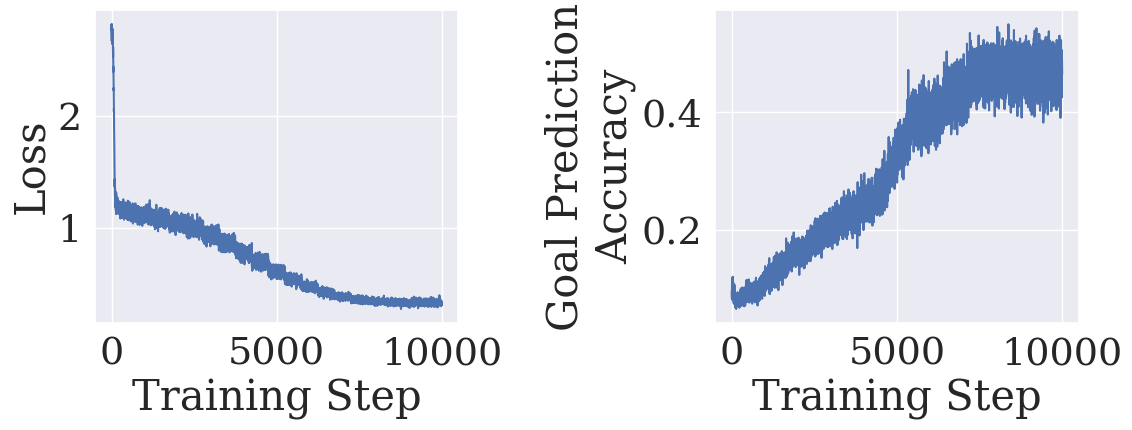

reformatted figures/state_decoding_23-11-24-early-stop/state_decoding_training_curves/code.py

All done! ✨ 🍰 ✨
1 file reformatted.


In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def plot_state_decoding_training_curves(df):

    set_plotting_style(font_scale=2.5)

    _, axs = plt.subplots(1, 2, figsize=(12, 5))

    sns.lineplot(df, x='step', y='loss', ax=axs[0])
    axs[0].set_xlabel('Training Step')
    axs[0].set_ylabel('Loss')
    sns.lineplot(df, x='step', y='goal_pred_acc', ax=axs[1])
    axs[1].set_xlabel('Training Step')
    axs[1].set_ylabel('Goal Prediction\nAccuracy')
    plt.tight_layout()

df = pd.DataFrame({
    'loss': metrics['loss'],
    'step': metrics['step'],
    'goal_pred_acc': metrics['goal_pred_acc'],
})


save_reproducible_figure(
    'state_decoding_training_curves',
    df, plot_state_decoding_training_curves, show=True,
    figures_dir=f'figures/state_decoding_{EXPERIMENT_NAME}'
)

In [88]:
rng = jax.random.PRNGKey(42)

inputs, traj_batch = sample_training_batch(rng)
obs_preds, action_pred_logits = obs_action_decoder.apply(
    obs_action_decoder_train_state.params, inputs, temp=1.0
)

predicted_ep = obs_preds.round(2)
pred_goal_pos, _ = get_goals_and_pos(predicted_ep)
act_goal_pos, _ = get_goals_and_pos(traj_batch.obs)

*_, seq_mask = inputs
delta_goal_pos = jnp.abs(pred_goal_pos - act_goal_pos)[jnp.logical_not(seq_mask)]
goal_pos_dist = jnp.linalg.norm(delta_goal_pos, ord=1, axis=-1)
goal_pos_dist_mean = goal_pos_dist.mean()
goal_pos_dist_std = goal_pos_dist.std()
goal_pos_dist_mean.item(), goal_pos_dist_std.item()

(0.5378605723381042, 0.5652256608009338)

In [89]:
items = {
    'seed': [],
    'pred_goal_pos_x': [],
    'pred_goal_pos_y': [],
    'act_goal_pos_x': [],
    'act_goal_pos_y': [],
    'pred_correct': []
}

N_SEEDS = 10

for seed in range(N_SEEDS):
    rng = jax.random.PRNGKey(seed)
    inputs, traj_batch = sample_training_batch(rng)
    obs_preds, action_pred_logits = obs_action_decoder.apply(
        obs_action_decoder_train_state.params, inputs, temp=1.0
    )

    *_, seq_mask = inputs
    pred_goal_pos, _ = get_goals_and_pos(obs_preds)
    pred_goal_pos = pred_goal_pos[jnp.logical_not(seq_mask)]
    act_goal_pos, _ = get_goals_and_pos(traj_batch.obs)
    act_goal_pos = act_goal_pos[jnp.logical_not(seq_mask)]
    goals_equal = (pred_goal_pos == act_goal_pos).all(axis=-1)

    items['seed'].extend([seed] * goals_equal.shape[0])
    items['pred_goal_pos_x'].extend(pred_goal_pos[:, 0].tolist())
    items['pred_goal_pos_y'].extend(pred_goal_pos[:, 1].tolist())
    items['act_goal_pos_x'].extend(act_goal_pos[:, 0].tolist())
    items['act_goal_pos_y'].extend(act_goal_pos[:, 1].tolist())
    items['pred_correct'].extend(goals_equal.tolist())


acc_df = pd.DataFrame(items)

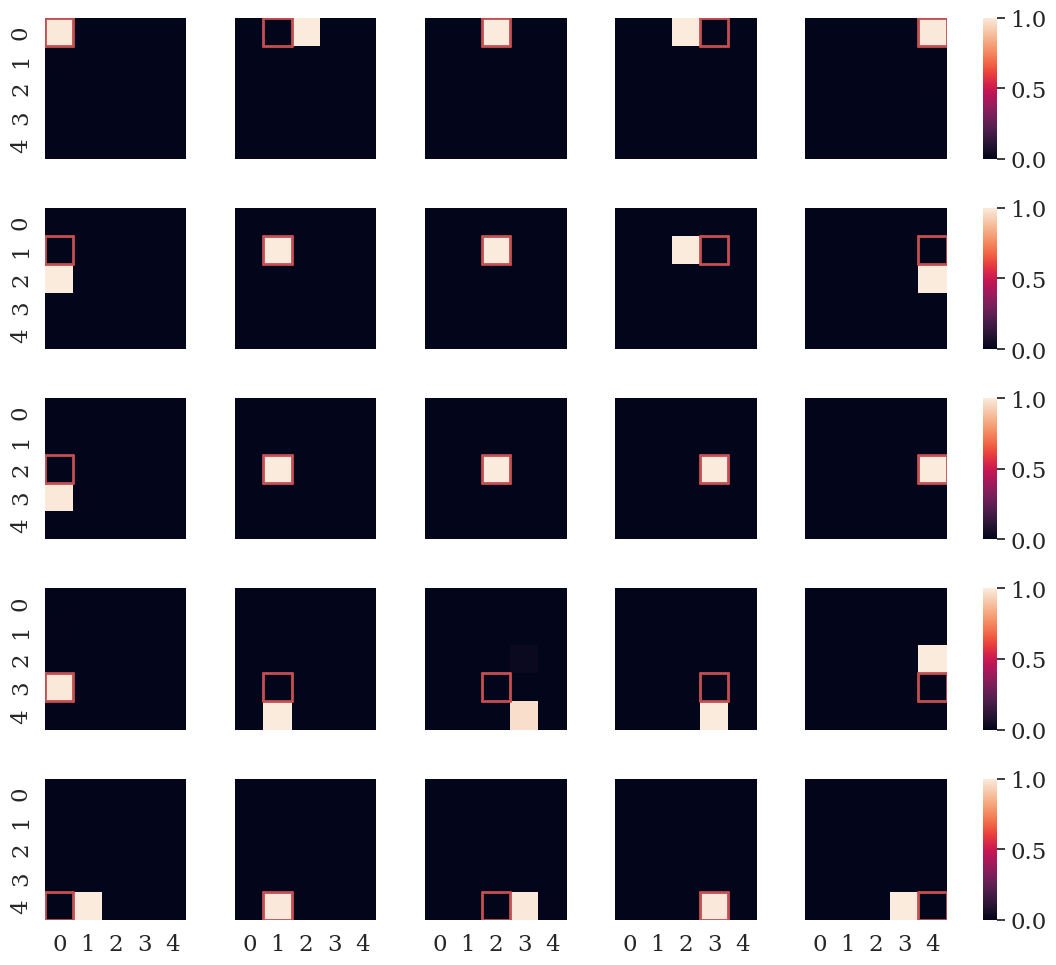

reformatted figures/state_decoding_23-11-24-early-stop/goal_predictions/code.py

All done! ✨ 🍰 ✨
1 file reformatted.


In [90]:
import matplotlib.gridspec as gridspec

def plot_goal_predictions(acc_df):
    set_plotting_style(font_scale=1.5)

    plt.figure(figsize=(11, 10))
    gs = gridspec.GridSpec(5, 6, width_ratios=[1, 1, 1, 1, 1, 0.1])

    for j in range(5):
        for i in range(5):
            true_x, true_y = j, i

            df = acc_df[(acc_df['act_goal_pos_x'] == true_x) & (acc_df['act_goal_pos_y'] == true_y)]

            preds_table = np.zeros((env_params.grid_size, env_params.grid_size))

            for row in df.itertuples():
                preds_table[row.pred_goal_pos_x, row.pred_goal_pos_y] += 1

            preds_table /= preds_table.sum()

            ax = plt.subplot(gs[j, i])
            sns.heatmap(
                preds_table,
                ax=ax,
                cbar=i == 4,
                cbar_ax=None if i != 4 else plt.subplot(gs[j, 5]),
                vmin=0, vmax=1,
                square=True
            )

            if i != 0:
                ax.set_yticks([])
                ax.set_ylabel('')
            else:
                ax.set_yticks(np.array([0, 1, 2, 3, 4]) + 0.5)
                ax.set_yticklabels(['0', '1', '2', '3', '4'])

            if j != 4:
                ax.set_xticks([])
                ax.set_xlabel('')
            else:
                ax.set_xticks(np.array([0, 1, 2, 3, 4]) + 0.5)
                ax.set_xticklabels(['0', '1', '2', '3', '4'])

            width = 2
            ax.plot([true_y, true_y + 1], [true_x, true_x], 'r', linewidth=width)
            ax.plot([true_y, true_y + 1], [true_x + 1, true_x + 1], 'r', linewidth=width)
            ax.plot([true_y, true_y], [true_x, true_x + 1], 'r', linewidth=width)
            ax.plot([true_y + 1, true_y + 1], [true_x, true_x + 1], 'r', linewidth=width)

        cbar_ax = plt.subplot(gs[j, 5])
        cbar_ax.set_aspect(10)  # Adjust this value to fine-tune

    plt.tight_layout()


save_reproducible_figure(
    'goal_predictions', acc_df, plot_goal_predictions, show=True,
    figures_dir=f'figures/state_decoding_{EXPERIMENT_NAME}'
)

In [91]:
def create_rollout_state(n_seqs, goal_pos, agent_pos, seed=0):
    reset_rng = jax.random.split(jax.random.PRNGKey(0), n_seqs)
    _, env_state = jax.vmap(env.reset,
                            in_axes=(0, None))(reset_rng, env_params)

    env_state = env_state.replace(
        env_state=env_state.env_state.replace(
            goal_pos=jnp.repeat(goal_pos[None], n_seqs, axis=0),
            agent_pos=jnp.repeat(agent_pos[None], n_seqs, axis=0)
        )
    )

    obsv = jax.vmap(env.get_obs)(env_state.env_state)

    ep_ids = jnp.arange(n_seqs)
    rng = jax.random.PRNGKey(seed)
    return (env_state, obsv, rng, ep_ids)


agent_pos = jnp.array([0, 0])
goal_pos = jnp.array([env_params.grid_size - 1, env_params.grid_size - 1])

samples = 512
rollout_state = create_rollout_state(samples, goal_pos, agent_pos)

dfs = []
for temp in [0.001, 0.01, 0.1, 1.0]:
    inputs, traj_batch = sample_sequences(
        jax.random.PRNGKey(0),
        n_seqs=samples,
        seq_len=10,
        rollout_state=rollout_state,
        action_sample_temp=temp
    )

    agent_pos = traj_batch.env_state.env_state.agent_pos
    seq_len, n_seqs, _ = agent_pos.shape
    *_, seq_mask = inputs
    agent_pos = agent_pos[jnp.logical_not(seq_mask)]
    df = pd.DataFrame(agent_pos, columns=['X', 'Y'])
    df['temp'] = temp
    dfs.append(df)

positions_temp_df = pd.concat(dfs)

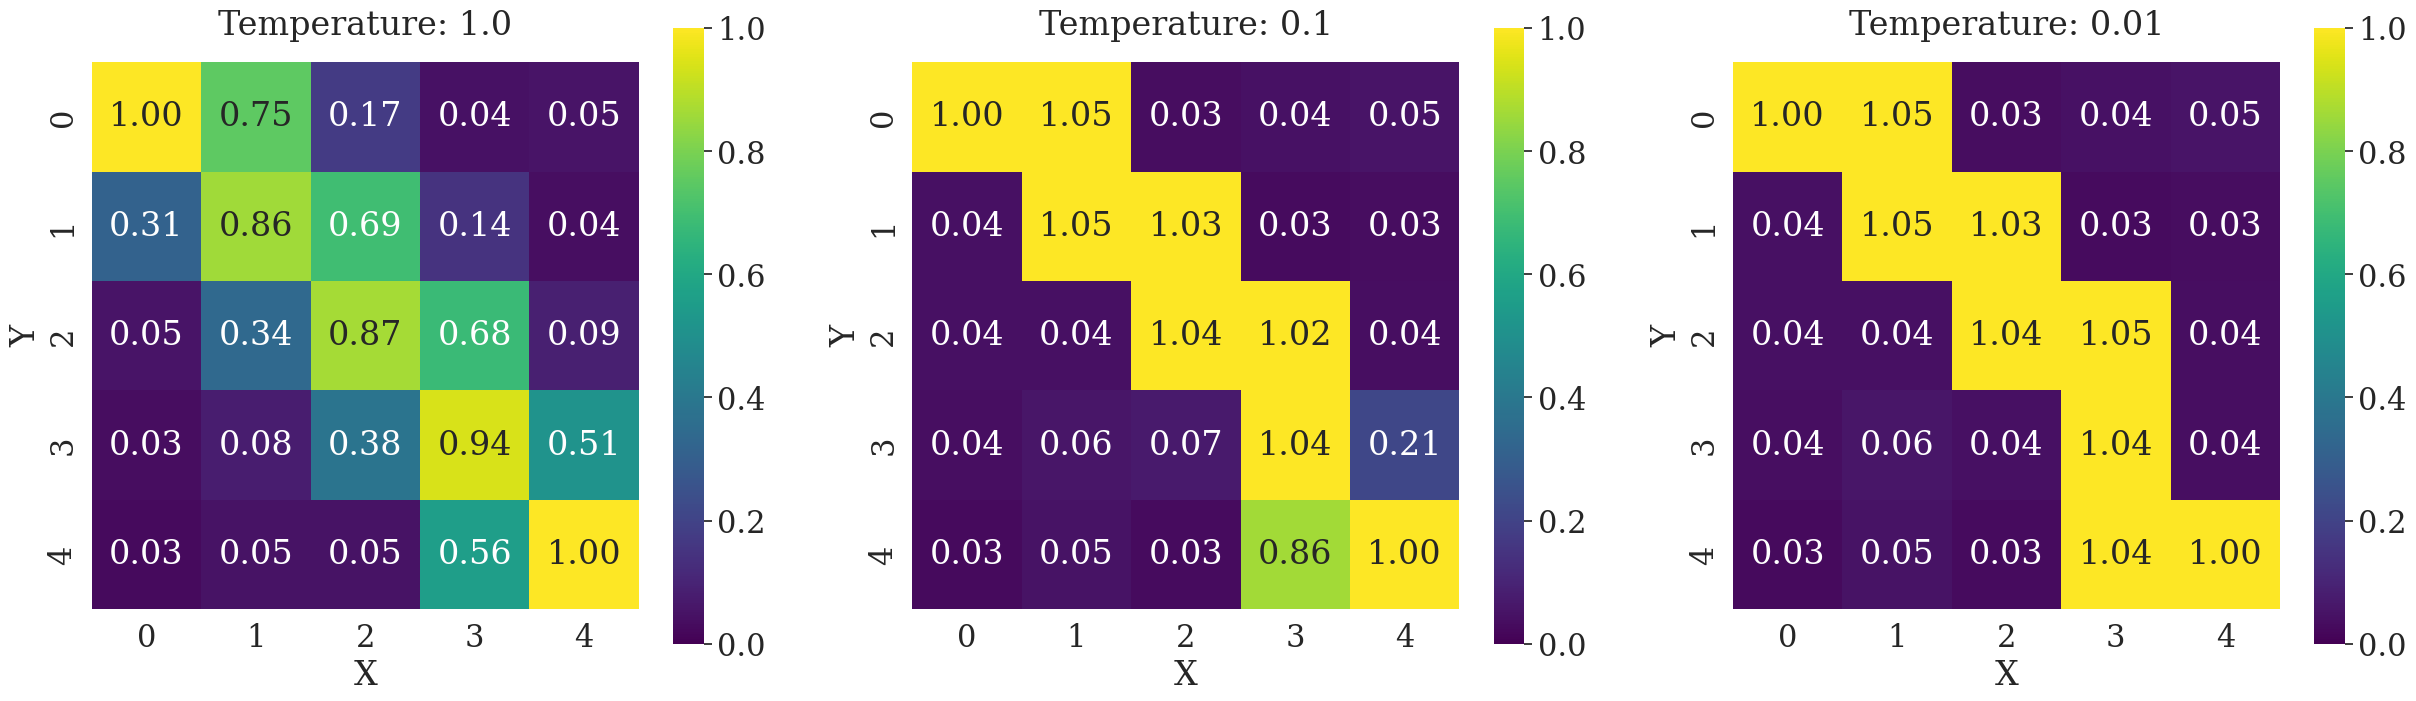

reformatted figures/policy_location_heatmap_w_temp/code.py

All done! ✨ 🍰 ✨
1 file reformatted.


In [164]:
def plot_policy_location_heatmap(agent_pos_df, grid_size, n_samples):
    agent_pos_df['idx'] = agent_pos_df['X'] * grid_size + agent_pos_df['Y']

    set_plotting_style(font_scale=2)

    _, axs = plt.subplots(1, 3, figsize=(30, 8))
    for i, temp in enumerate([1.0, 0.1, 0.01]):
        df = agent_pos_df[agent_pos_df['temp'] == temp]
        location_heatmap = df.groupby(['X', 'Y'])['idx'].count().reset_index().pivot(index='X', columns='Y', values='idx')
        location_heatmap[grid_size - 1][grid_size - 1] = n_samples
        location_heatmap[0][0] = n_samples
        ax = axs[i]
        sns.heatmap(
            location_heatmap.T / n_samples,
            cmap='viridis', cbar=True,
            annot=True, fmt='.2f',
            square=True,
            ax=ax,
            vmin=0, vmax=1
        )
        ax.set_title(f'Temperature: {temp}', pad=20)


save_reproducible_figure(
    'policy_location_heatmap_w_temp', 
    positions_temp_df,
    plot_policy_location_heatmap,
    show=True,
    grid_size=env_params.grid_size,
    n_samples=samples,
)